In [2]:
import numpy
import PIL
from PIL import Image, ImageFilter
from PIL import ImageDraw
from PIL import ImageOps
import sys
import os
import matplotlib.pyplot as plt
import random
import math

In [3]:
def find_coeffs(pa, pb):
	matrix = []
	for p1, p2 in zip(pa, pb):
		matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
		matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

	A = numpy.matrix(matrix, dtype=numpy.float)
	B = numpy.array(pb).reshape(8)

	res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
	return numpy.array(res).reshape(8)


def generate_random_shifts(img_size, factor):
	w = img_size[0] / factor
	h = img_size[1] / factor
	shifts = []
	for s in range(0, 4):
		w_shift = (random.random() - 0.5) * w
		h_shift = (random.random() - 0.5) * h
		shifts.append((w_shift, h_shift))
	return shifts


# create random perspective
def create_perspective(img, factor):
	img_size = img.size
	w = img_size[0]
	h = img_size[1]
	shifts = generate_random_shifts(img_size, factor)
	coeffs = find_coeffs(
		[(shifts[0][0], shifts[0][1]),
			(w + shifts[1][0], shifts[1][1]),
			(w + shifts[2][0], h + shifts[2][1]),
			(shifts[3][0], h + shifts[3][1])], [(0, 0), (w, 0), (w, h), (0, h)])
	return img.transform((w, h), Image.PERSPECTIVE, coeffs, Image.BICUBIC)


# due to rotation and/or perspective we will need to fill in the background
def mask_image(img):
	mask = Image.new("RGBA", img.size, (255, 255, 255, 255))
	return Image.composite(img, mask, img)


# will adjust the canvas so that perspective transforms will not result in the image being cropped
# also adjusts the image to be square along largest dimension - makes things easier later on
# assumes the image background is white...
def adjust_canvas(img, factor):
	padding_factor = 4  # allows more space for image distortion
	width, height = img.size
	# choose largest dimension
	img_largest_dim = (width, height)[width < height]
	canvas_dim = int(math.floor(img_largest_dim + (padding_factor * (img_largest_dim / factor))))
	canvas_size = (canvas_dim, canvas_dim)
	img_pos = (int(math.floor((canvas_size[0] - width) / 2)), int(math.floor((canvas_size[1] - height) / 2)))
	new_canvas = Image.new("RGBA", canvas_size, (255, 255, 255, 255))
	new_canvas.paste(img, (img_pos[0], img_pos[1], img_pos[0] + width, img_pos[1] + height))
	return new_canvas


# will randomly rotate the image

def rotate_image(img, rotation):
	# we want to have random rotations but my feeling is 
	# we should have more smaller rotations than larger
	# this skews the random numbers toward zero
	rotation_factor = math.pow(random.uniform(0.0, 1.0), 4)
	# we want to rotate either way
	rotation_direction = (1, -1)[random.random() > 0.5]
	rotation_angle = int(math.floor(rotation * rotation_factor * rotation_direction))
	return img.rotate(rotation_angle)


# crop the image to a square that bounds the image using largest bounding-box dimension
# and then resize the image to the size desired for the neural net training
def crop_resize(img, dimension):
	inv_img = ImageOps.invert(img.convert("RGB"))
	# returns left, upper, right, lower
	left, upper, right, lower = inv_img.getbbox()
	width = right - left
	height = lower - upper
	if width > height:
		# we want to add half the difference between width and height
		# to the upper and lower dimension
		padding = int(math.floor((width - height) / 2))
		upper -= padding
		lower += padding
	else:
		padding = int(math.floor((height - width) / 2))
		left -= padding
		right += padding

	img = img.crop((left, upper, right, lower))

	# Image.LANCZOS
	# Image.BICUBIC
	return img.resize((dimension, dimension), Image.LANCZOS)


# pulls together all the methods to distort and finalise the image
def distort_image(img, factor, rotation, dimension):
	img = create_perspective(img, factor)
	img = rotate_image(img, rotation)
	img = mask_image(img)
	img = crop_resize(img, dimension)
	return img

def resize(im1, im2):
    return ImageOps.fit(im2, (im1.width, im1.height), Image.ANTIALIAS)

def resizeBlend(im1, im2, alpha):
    im2 = resize(im1, im2)
    return Image.blend(im1, im2, alpha)

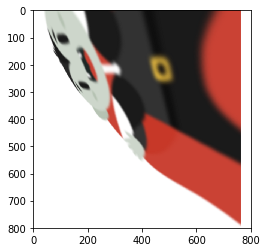

In [4]:
im = Image.open("vamp.png")
im = im.filter(ImageFilter.GaussianBlur(radius = 5)) 
water = Image.open("water2.png")
im2 = distort_image(im, 1, 0, 800)
plt.figure()
plt.imshow(im2)

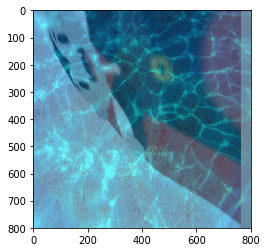

In [5]:
im3 = resizeBlend(im2, water, 0.6)
plt.figure()
plt.imshow(im3)